In [1]:
import sys
import os.path
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive') 
  if not os.path.isfile('SETTINGS.json'):
       # hard coded data directory in drive is used if SETTINGS.json not present 
       config={}
       config['DATA_DIR'] = '/content/gdrive/My Drive/kaggle-c1'
       with open('SETTINGS.json', 'w') as outfile:
         json.dump(config, outfile)

with open('SETTINGS.json') as config_file:
    config = json.load(config_file)

DATA_DIR = config['DATA_DIR']

print('Using DATA_DIR ', DATA_DIR)


Using DATA_DIR  /home/vvi/repos/c1-final/datadir


In [2]:
DATA_FOLDER = DATA_DIR

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))
test_spec = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

# Data leak analysis

Data leaks are the flow of such information to the data science contest participants that would not be available
if the data science task would be performed in a real life setting, not as a task in a contest. 

Examples of possible mechanisms for data leaks:
* leaks through the contest leaderboard
* temporal overlapping or interleaving of training and testing periods, if the task involves a temporal element
* naming of variables in a prediction task so that the names reveal something about the true values of the target variable in the test set
* numerical encoding categorical variable values so that the ordering reveal something about the true values of the target variable in the test set
* ordering the test cases so that the ordering reveal something about the true values of the target variable in the test set

In a general case, analysis can not rule out the possibility of data leaks to exist. It is only possible to positively identify 
data leaks. One can also hypothesise mechanisms for data leaks and check whether they really exist in the particular contest at hand.



## Leaderboard

Every time a contestant receives a score on the leaderboard for his submission, some leakage of information happens: how close 
the submission was to the prediction target. The leaderboard can be systematically probed to bring the submissions closer to the target.

Any validation of submissions on the leaderboard causes some data to leak through the leaderboard. However, in the case of the current C1 contest 
the submissions have so many independent entries, i.e. large information content, that the amount of information leaking through the leaderboard
is minor in comparison. On the other hand, the importance of the data leak by LB validation increases in the case of this contest, as it is difficult to construct other alternative validation mechanisms that would accurately reflect the characteristics of the evaluation data. 

Our solution to the prediction task employs leaderboard probing as a post-processing step to determine the optimal scaling of the predictions. More aggressive validation on the leaderboard would have probably resulted in better accuracy of predictions.

Contests often have separate public and private leaderboards. Maximising the private leaderboard score can uaually be regarded as the real task 
of the contest. One type of data leak is the leakage between public and private leaderboards. Without such leakage, even exhaustive probing of the public leaderboard would only provide an additional training set for the private prediction task. However, in this contest the private and public leaderboards temporally share the same evaluation period, as shown by the analysis in the next notebook cells, and seemingly randomly split the evaluation cases between the two leaderboards. Consequently, the evaluation sets seem to share many statistics and at least the similar temporal trend in comparison with the training data. This means that in this contest, probing the public leaderboard almost directly reveals how to improve in the private prediction task. This is evidenced also by the following scatter plot that shows the correlation between public and private leaderboard scores of some of our recent submissions, evaluated by the Coursera grader.




<AxesSubplot:>

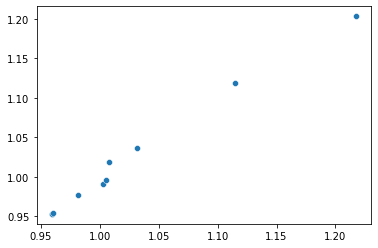

In [3]:


# public/private leaderboard score pairs from our recent submissions

public_scores=[
    0.959457,
    0.959404,
    0.960635,
    1.003010,
    0.981348,
    1.005539,
    1.007823, 
    1.031497,
    1.114415,
    1.217538, 
]
private_scores=[
    0.953158,
    0.953130,
    0.954215,
    0.991288,
    0.977585,
    0.996209,
    1.019363,
    1.036105,
    1.119150,
    1.203256
]

sns.scatterplot(x=public_scores, y=private_scores)

We see there is rather direct leak between public and private leaderboards. In the context of the Coursera course
this bears no practical significance as the Coursera grader directly reports also the private leaderboard score. In this case, there is no need to use the public LB as a proxy for the private LB. In a standard Kaggle competition setting where only the public LB can be probed, the situation would be different, and the private LB score could be improved by probing the public leaderboard.   

## Temporal arrangement of data

If the prediction task involves a temporal element, data leaks are practically unavoidable unless training and test data originate from distinct time intervals. In the present competition, the training and test data time periods indeed are temporally distinct and not interleaved. Time interval overlap does not cause data leaks here.

The public and private leaderboards, however, share the same time period and there is rather direct data leak between them. As mentioned already before, this does not have any pratical consequences in the Coursera project setting, however. 

## Naming of variables

It does not seem plausible that the provided variable names
* shop_id
* item_id
* item_name
* item_category_id
* item_category_name

could have been determined on the basis of the target variable values in the test set.

## Numerical encoding of categorical variables

A data leak could occur if some of the categorical variables would have been encoded in such a way that
the numerical encoding was based on some statistic of the test set. We can rule out such data leaks if we can find out some other reason behind the encoding scheme of variables

### Shop_id
Shop_id seems to be assigned by alphabetical order of shop names. No data leak here.

### Item_id

Item_id seems to be assigned by alphabetical order of item names. No data leak here either.

### Item_category_id

Item_category_id seems to be assigned by alphabetical order of item category names. No data leak here either.

## Order of appearance in the test set

As found out in the EDA part, the test set specification enumerates all the combinations of shops and item ids from lists of active shops and items. However, the order of appearance could be based on some statistic of the test set, which could be potentially source af a data leak. 

<AxesSubplot:xlabel='ID', ylabel='shop_id'>

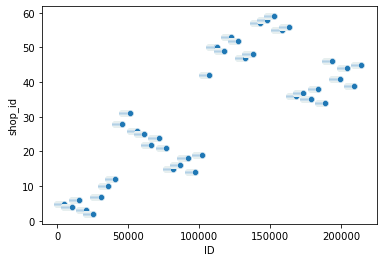

In [4]:
sns.scatterplot(data=test_spec, x='ID', y='shop_id')

From the above plot we see that the shops do not appear in the order of shop_id's in the test set. There may be some other explanation. The above figuremay be a bit unclear but it seems that all items in one shop are listed as one sequence and then same is repeated for other shops, i.e. there is 

<AxesSubplot:xlabel='ID', ylabel='item_id'>

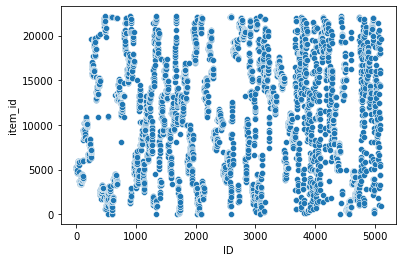

In [5]:
sns.scatterplot(data=test_spec[test_spec['shop_id']==5], x='ID', y='item_id')

The above figure indicates that item_id's do not occur in numerical order in the test set specification.
Let's check with the following code whether the ordering of items is the same for every shop:

In [6]:
shop_list = test_spec.shop_id.unique()
item_list0 = test_spec[test_spec['shop_id']==shop_list[0]].item_id.to_numpy() 
same_order=True
for id in shop_list:
    item_list = test_spec[test_spec['shop_id']==id].item_id.to_numpy() 
    comparison = item_list == item_list0
    if not comparison.all():
        same_order=False
        
print(same_order)        
    

True


The assumption of the same item ordering within each shop is thus correct.

It is plausible that the lists of shops and items would have been ordered ("rank") according to their order of appearance in the original transactional data for the target month December 2015. In that case one would expect some negative correlation between rank and monthly sales figures: popular items would be more likely to appear first in the transactions. If the correlation exists, it is expected to be weaker for shop ranks (to the point of not practically significant) and stronger for item ranks (since even less popular shops are likely produce sales already the first day).


Let's now augment the test set specification with columns where the shops and items are represented with their order of appearance in the test set ("rank"). We would like to investigate whether the ranks correlate with the target variable in the test set. The target is naturally unknown, but we can try to use our current best predictions (without exploiting data leaks) as a proxy.


In [7]:
predictions= pd.read_csv(os.path.join(DATA_FOLDER, 'prediction.csv'))
test_spec_augmented=pd.merge(test_spec, predictions, how='left', on=['ID']).fillna(-1)

items_per_shop = len(item_list0)
test_spec_augmented['shop_rank']=test_spec.ID.to_numpy() // items_per_shop
test_spec_augmented['item_rank']=test_spec.ID.to_numpy() % items_per_shop

<AxesSubplot:xlabel='shop_rank', ylabel='item_cnt_month'>

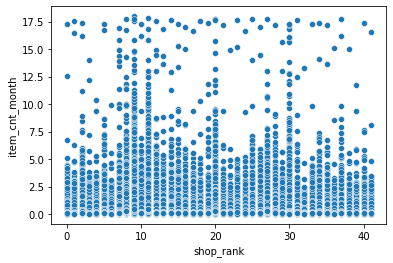

In [8]:
sns.scatterplot(data=test_spec_augmented,x='shop_rank',y='item_cnt_month')

<AxesSubplot:xlabel='item_rank', ylabel='item_cnt_month'>

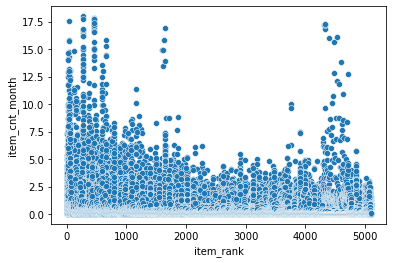

In [9]:
sns.scatterplot(data=test_spec_augmented,x='item_rank',y='item_cnt_month')

As expected, rank of shops may not show any correlation with the target variable. However, there might be some negative correlation in the case of item ranks. Let's make the images less cluttered by averaging all entries with the same shop_rank (or item_rank) 

<AxesSubplot:xlabel='shop_rank', ylabel='item_cnt_month'>

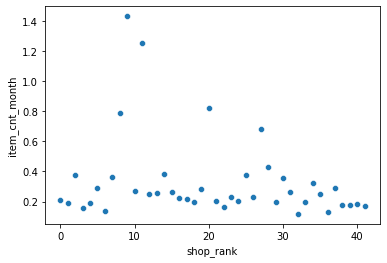

In [10]:
gb_shop = test_spec_augmented.groupby(['shop_rank'],as_index=False).agg({'item_cnt_month':'mean'})
sns.scatterplot(data=gb_shop,x='shop_rank',y='item_cnt_month')

<AxesSubplot:xlabel='item_rank', ylabel='item_cnt_month'>

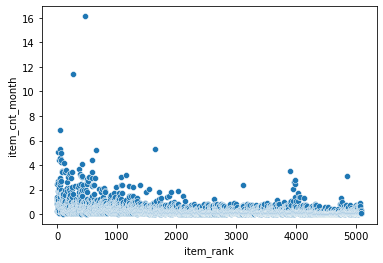

In [11]:
gb_item = test_spec_augmented.groupby(['item_rank'],as_index=False).agg({'item_cnt_month':'mean'})
sns.scatterplot(data=gb_item,x='item_rank',y='item_cnt_month')

The plot above seems to confirm that there is no correlation to be seen in the case of shop rank. For item rank the situation is 
less clear as the plot is still cluttered many data points, and visually dominated by outliers. There might still be slight negative correlation. Let's make the figure even less cluttered by grouping together 

<AxesSubplot:xlabel='item_rank_100', ylabel='item_cnt_month'>

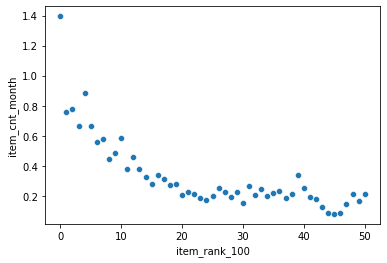

In [12]:
test_spec_augmented['item_rank_100']=test_spec_augmented['item_rank'] // 100
sns.scatterplot(data=test_spec_augmented.groupby(['item_rank_100'],as_index=False).agg({'item_cnt_month':'mean'}),x='item_rank_100',y='item_cnt_month')


This plot shows clear negative correlation and seems to validate our hypothesis for the item category ordering in the test set specifications. A potential data leak has been identified.

Potential is there and the mechanism appears believable. However, it remains still unclear how much data leakage there actually is. That is, would the item rank variable provide any additional information besides the information already obtainable from other sources? The observed correlation was predicted by such variables alone that do not take the item rank into account. Item rank would provide additional value only if there would actually be even stronger correlation between the rank and the real monthly sales variable (instead of our prediction).

In principle it would be straightforward to try out whether the item rank in the target month would provide useful. However, 
in order to properly do this, one would need to generate similar ordered item lists individually for each training month and 
use the ranks in these lists for training. This would require lots of work and is omitted this time.
